In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns


import sys, re, time, json
from PSlim import Experiment, get_eps, ROC

pyslurm = '/home/enes/pyslurm/'
#pyslurm = None

In [2]:
Train = False # if you do analysis with given simulations and estimates

In [3]:
if pyslurm:
    sys.path.append(pyslurm)
    from pyslurm import Slurm

    slurm = Slurm(account='stats_dept1')

    srun = slurm.batch('source activate slim', 
                       '#time=0-1:00:00',
                       '#mem=1000M',
                       '#mem-per-cpu=None', 
                       '#job-name="sim"')   

    srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
                           '#mem-per-cpu=300',
                           '#job-name="est"',
                           '#cpus-per-task=3')

### Parameters:

In [4]:
N = 250
Ne = 1000
L = 2500
r = 1.25e-7
mu = 2.5e-7

extmut = 0 # no extra mutation (just one)
Until = 100000 # make sure model runs until it reaches the desired frequency Until>>Ne

Args = {}

Args['Neut'] = {'Simulator':'slim', 'slimTxt':'Constant_mt.txt', 
                'N':N, 'L':L, 'r':r, 'mu':mu, 'Ne':Ne,
                'Until':Until,
                's':0, 'h':0.5, 
                'srun':srun, 'srun_est':srun_est,
                'etapath':'etas/BC.json', 'start': Until + 100,
                'name':'Neutral Model',
                'Freq':1000000,
                'rep':0,
                'reset_lost': 0}

h = 25
for Until in [2000, 3000, 4000, 5000]:
    for s in [0.01/h, 0.02/h, 0.05/h]:
        name = 'until='+str(Until)+'s='+str(s)
        arg = Args['Neut'].copy()
        arg['s'] = s
        arg['h'] = h
        arg['name'] = name
        arg['reset_lost'] = 1
        arg['Until'] = Until
        Args[name] = arg

In [5]:
cID = 8 # simulation class id for directional selection constant pop size simulations
nrep = 250
X = Experiment(cID, nrep, Args)

## 1 Simulation

In [299]:
if Train:
    X.sim()

If you are using HPC (srun is not None) check the jobs!


In [287]:
slurm.queue()

,JOBID,PARTITION,NAME,USER,ACCOUNT,ST,TIME,NODES,NODELIST(REASON)
0,20060379,standard,sys/dash,enes,stats_de,R,1-22:29:38,1,gl3383


## 2 Population Size History estimation

In [6]:
X.calc_sfs()
X.train_eta()

Done!


Neut 3951
until=5000s=0.0004 4711
until=4000s=0.0004 4255
until=5000s=0.0008 4537
until=2000s=0.0004 3741
until=3000s=0.0008 4015
until=3000s=0.002 3377
until=3000s=0.0004 4048
until=2000s=0.002 3019
until=4000s=0.0008 4283
until=4000s=0.002 3545
until=2000s=0.0008 3710
until=5000s=0.002 3734


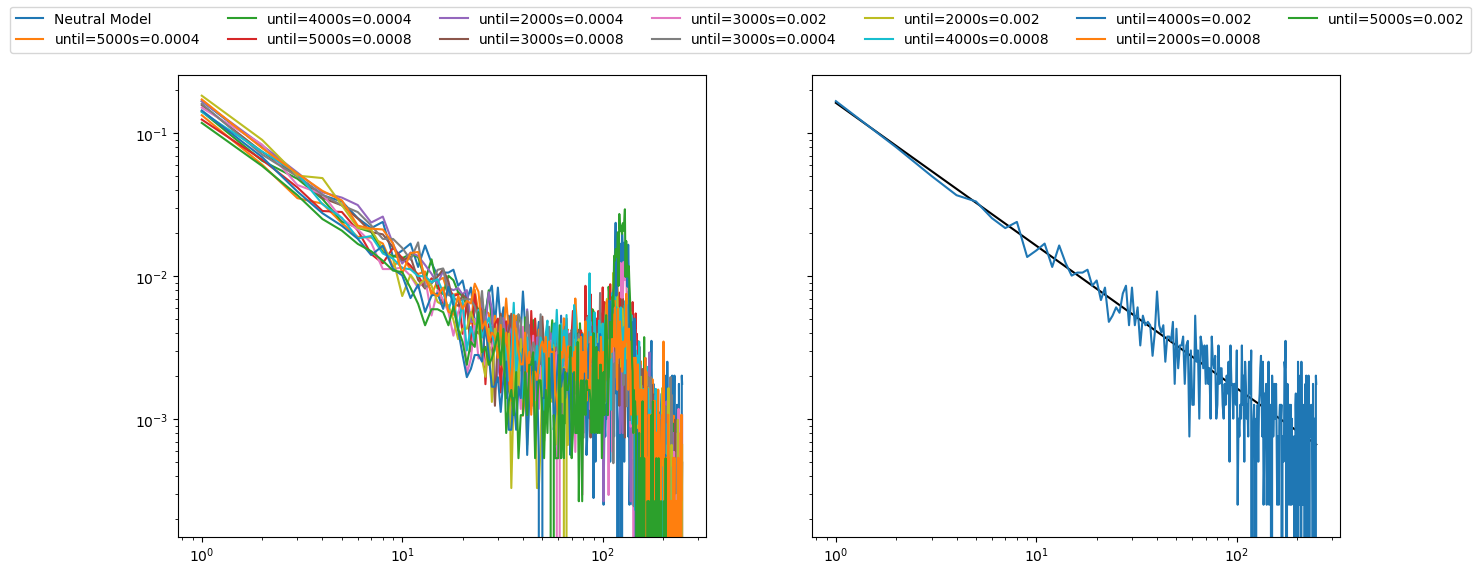

In [7]:
fig, ax = plt.subplots(1,2,figsize = (15,6), sharex=True, sharey=True)

for setid in X.neutrals:
    name = Args[setid]['name']
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.ebl[setid]/X.ebl[setid].sum(), color = 'black')
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum())
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)
    print(setid, X.AFS[setid].sum())

for setid in set(X.setids).difference(X.neutrals):
    name = Args[setid]['name']
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)
    print(setid, X.AFS[setid].sum())

ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.legend(ncol = 7, loc = 'upper center')

## 3 Optimizing $\beta$-imbalance and calculating summary stats

In [78]:
BIM = '/home/enes/bim/BIM.py'

if Train:
    for setid in X.setids:
        X.est(BIM, setid, now = 30, srun = srun_est, arg = '--r2t=0.005 --r2s=0.001 --treew=branch')

If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!


In [81]:
slurm.queue()

,JOBID,PARTITION,NAME,USER,ACCOUNT,ST,TIME,NODES,NODELIST(REASON)
0,20193117,standard,sys/dash,enes,stats_de,R,2:11:17,1,gl3060


In [82]:
if Train:
    for setid in X.setids:
        X.merge_outs(setid)

## 4 Analysis

In [91]:
stats = ['bsfs', 'TajD', 'ibtree', 'iColless']

### ROC Curves

In [92]:
myorder = [2, 3, 0, 1]

In [93]:
aucs = {stat:[] for stat in stats}

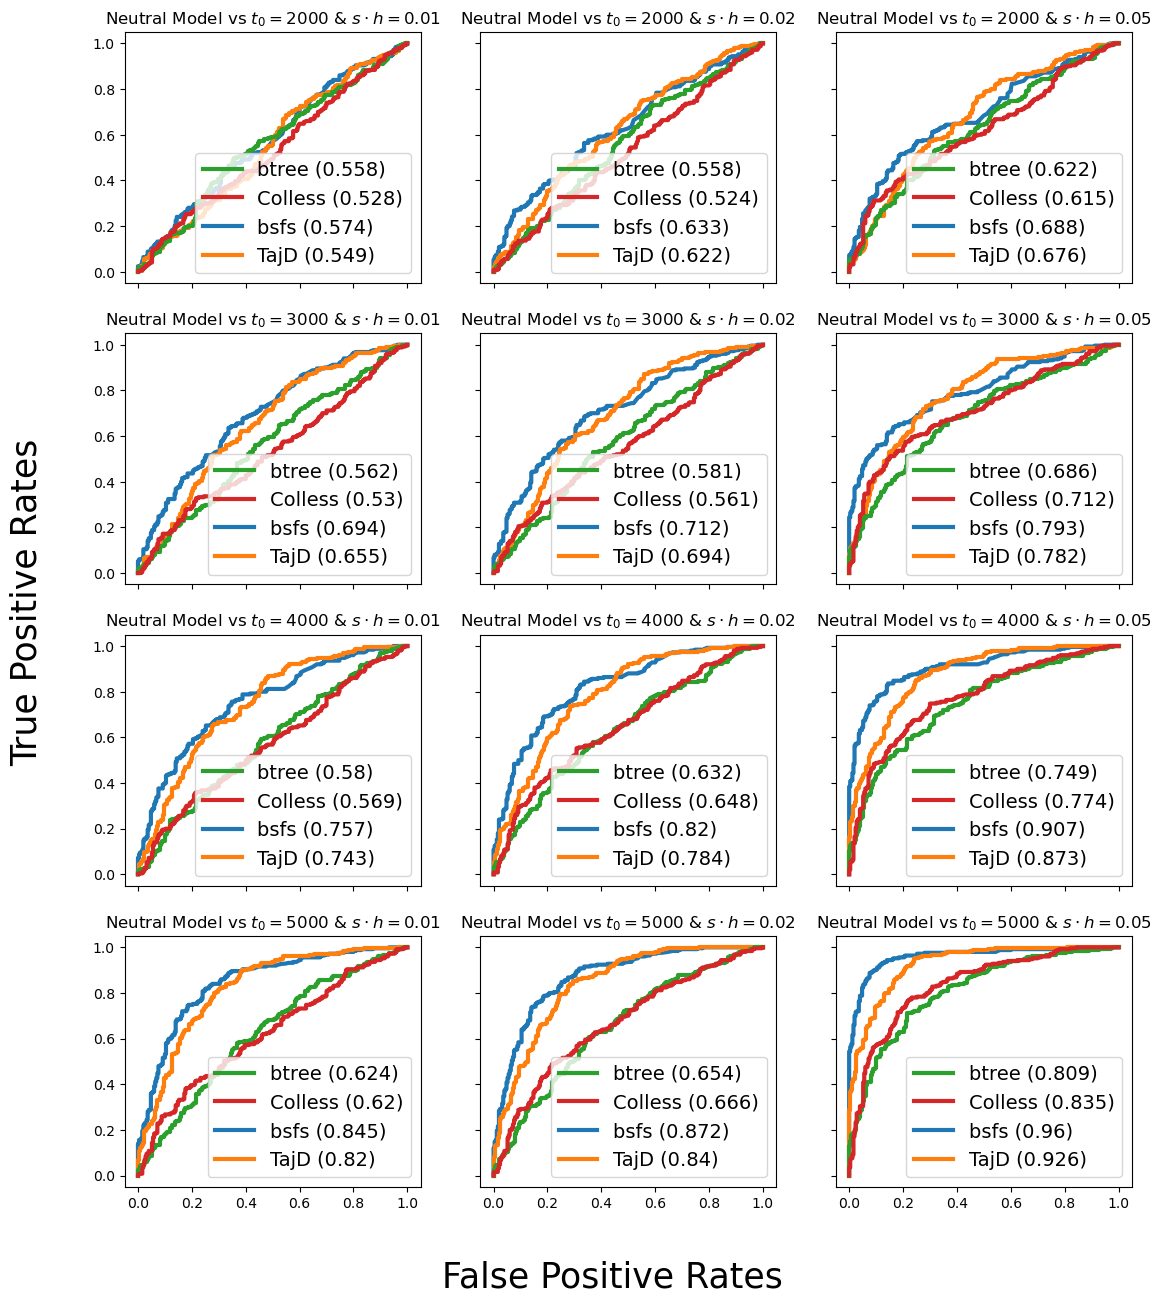

In [94]:
fig, ax = plt.subplots(4,3,figsize = (13,15), sharex = True, sharey = True)

for j, Until in enumerate([2000, 3000, 4000, 5000]):
        
    Vs = [['Neut', 'until='+str(Until)+'s='+str(s)] for s in [0.01/h, 0.02/h, 0.05/h]]
    names = [['Neutral Model', '$t_0='+str(Until)+'$ & $s\cdot h='+str(s*h)+'$'] for s in [0.01/h, 0.02/h, 0.05/h]]
    
    for i, vs in zip(range(len(Vs)), Vs):
        for key in stats:
            k1, k2 = vs
            df1 = pd.read_csv(X.df[k1]).dropna()
            df2 = pd.read_csv(X.df[k2]).dropna()
            for pos in ['iColless', 'FulD']:
                df1[pos] = -df1[pos]
                df2[pos] = -df2[pos]
            
            if key == 'ibtree':
                label = 'btree'
            elif key == 'iColless':
                label = 'Colless'
            else:
                label = key
            
            auc = ROC(ax[j, i], df1[key], df2[key], score_ascending = True, label = label)
            aucs[key].append(auc)
            
            
            
            
        handles, labels = ax[j,i].get_legend_handles_labels()
        ax[j, i].legend([handles[_] for _ in myorder], [labels[_] for _ in myorder], loc = 'lower right',
                       prop={'size': 14})

            
    for i, vs in zip(range(len(Vs)), Vs):
        k1, k2 = vs
        ax[j, i].set_title(names[i][0]+' vs '+names[i][1])
        
fig.text(0.5, 0.05, 'False Positive Rates', ha='center', va='center', size = 25)
fig.text(0.05, 0.5, 'True Positive Rates', rotation = 90, ha='center', va='center', size = 25)
plt.savefig('plots/Constant_Balancing.jpg', dpi = 300)

In [95]:
from scipy.stats import wilcoxon
aucs = pd.DataFrame(aucs)

In [98]:
wilcoxon(aucs['bsfs'], aucs['TajD'], alternative = 'greater')[1], (aucs['bsfs']-aucs['TajD']).mean()

(0.0011088607321185246, 0.024214000000000013)

In [97]:
wilcoxon(aucs['ibtree'], aucs['iColless'], alternative = 'greater')[1], (aucs['ibtree']-aucs['iColless']).mean()

(0.3189350899489728, 0.002639333333333336)

### Box plots

5000

In [26]:
] for s in [0.01/h, 0.02/h, 0.05/h]

,path,bsfs,TajD,btree,ibtree,iColless,setid
0,8000000,1.279487e-06,-0.656431,-0.565180,-3.398938,0.083495,Neutral Model
1,8000001,1.351304e+00,1.504250,0.461440,-1.560243,0.053375,Neutral Model
2,8000002,7.942844e-07,0.326015,-0.396978,-1.321197,0.051521,Neutral Model
3,8000003,-1.371017e+00,-1.438586,-0.553950,-1.895911,0.073423,Neutral Model
4,8000004,1.690526e-05,-0.401883,0.538843,-0.898612,0.050687,Neutral Model
...,...,...,...,...,...,...,...
245,8120245,4.511196e+00,2.180160,0.736212,-1.218064,0.050986,until=5000s=0.002
246,8120246,4.973638e+00,3.008540,0.876158,0.153746,0.034137,until=5000s=0.002
247,8120247,3.616453e+00,2.333424,0.629553,0.334891,0.031546,until=5000s=0.002
248,8120248,4.323800e+00,2.153047,0.214220,-0.218418,0.037138,until=5000s=0.002


In [30]:
df

,path,bsfs,TajD,btree,ibtree,iColless,setid
0,8120000,5.020108,2.480262,-0.330830,0.017748,0.038541,$t_0=5000$ & $s=0.002$
1,8120001,3.389589,2.104993,0.610549,-0.791855,0.045731,$t_0=5000$ & $s=0.002$
2,8120002,3.392809,0.045665,-0.542007,-0.471753,0.035853,$t_0=5000$ & $s=0.002$
3,8120003,1.348770,0.763237,-0.093669,0.101832,0.032048,$t_0=5000$ & $s=0.002$
4,8120004,0.986076,1.128759,1.175008,0.476241,0.030347,$t_0=5000$ & $s=0.002$
...,...,...,...,...,...,...,...
245,8120245,4.511196,2.180160,0.736212,-1.218064,0.050986,$t_0=5000$ & $s=0.002$
246,8120246,4.973638,3.008540,0.876158,0.153746,0.034137,$t_0=5000$ & $s=0.002$
247,8120247,3.616453,2.333424,0.629553,0.334891,0.031546,$t_0=5000$ & $s=0.002$
248,8120248,4.323800,2.153047,0.214220,-0.218418,0.037138,$t_0=5000$ & $s=0.002$


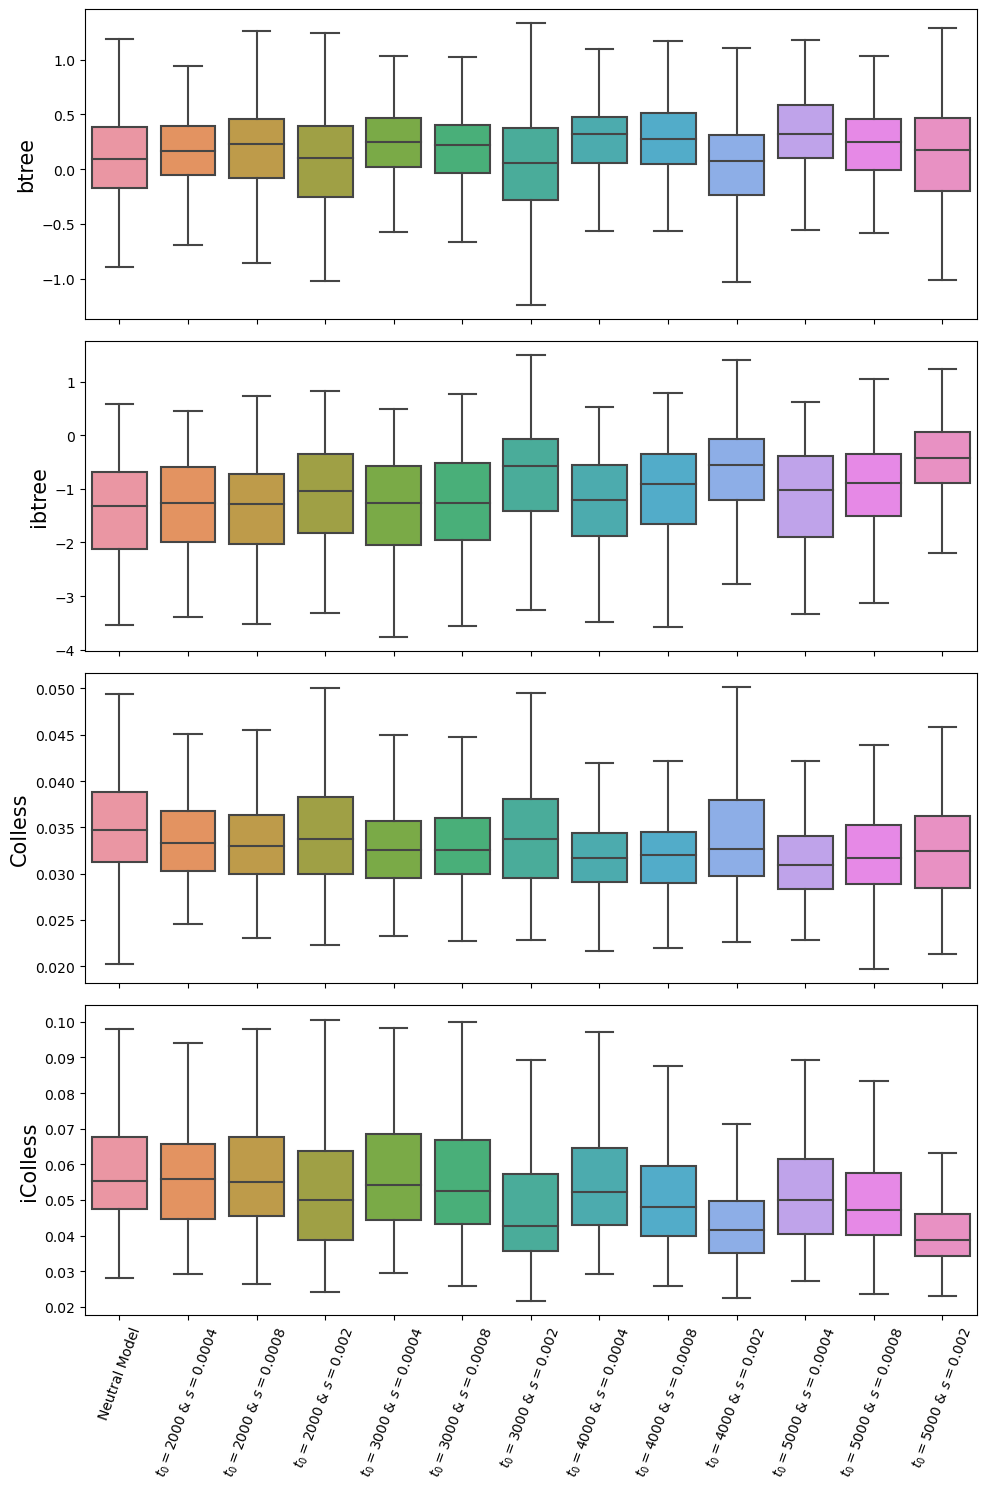

In [56]:
stats2 = ['btree', 'ibtree', 'Colless', 'iColless']

dfs = []
for setid in X.setids:
    df = pd.read_csv(X.df[setid])[['path']+stats2]
    if setid == 'Neut':
        name = 'Neutral Model'
    else:
        name = '$t_0='+str(Args[setid]['Until'])+'$ & $s='+str(Args[setid]['s'])+'$'
    df['setid'] = name
    dfs.append(df)





fig, ax = plt.subplots(len(stats2),figsize = (10,15), sharex = True)   
plt.xticks(rotation = 70)
dfs = pd.concat(dfs)

for i, stat in enumerate(stats2):
    sns.boxplot(data=dfs, x='setid', y=stat, ax=ax[i], showfliers = False)
    ax[i].set_ylabel(stat, size = 15)
    ax[i].set_xlabel(None)
plt.tight_layout()
plt.savefig('plots/Constant_Balancing_box.jpg', dpi = 300)